In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
#export
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

In [3]:
#export
import pandas as pd

## Load files for phase contrast images

In [4]:
#export
from pathlib import Path
import PIL,os,mimetypes

In [5]:
#export
Path.ls = lambda x: list(x.iterdir())[:10]

In [8]:
path= Path('../PCImages')

In [9]:
path.ls()

[PosixPath('../PCImages/171220_170148_stretch.png'),
 PosixPath('../PCImages/161125_131633_relax.png'),
 PosixPath('../PCImages/161125_131633_stretch.png'),
 PosixPath('../PCImages/161125_131633_trap.png'),
 PosixPath('../PCImages/161125_131649_relax.png'),
 PosixPath('../PCImages/161125_131649_stretch.png'),
 PosixPath('../PCImages/161125_131649_trap.png'),
 PosixPath('../PCImages/161125_131710_relax.png'),
 PosixPath('../PCImages/161125_131710_stretch.png'),
 PosixPath('../PCImages/161125_131710_trap.png')]

In [10]:
img_fn= path.ls()[0]

In [11]:
img_fn

PosixPath('../PCImages/171220_170148_stretch.png')

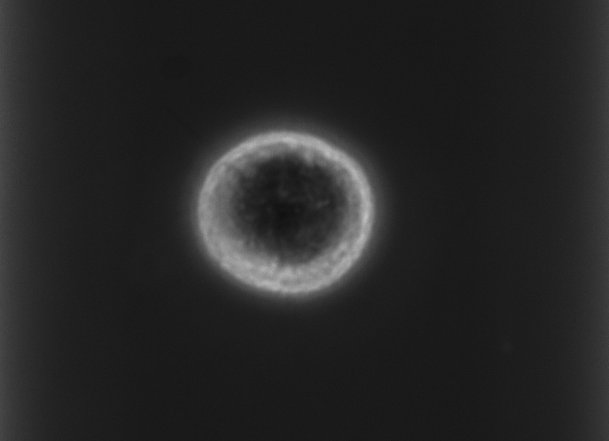

In [12]:
PIL.Image.open(img_fn)

## Get labels from the feature matrix

In [17]:
path2fm= '../FeatureMatsMerged/TheGreatCollection.txt'

In [21]:
path2colnames= 'FeatureMatIndex.txt'

In [88]:
#export
def fm_from_txt(path2fm, path2colnames):
    path_fm= Path(path2fm)
    fm_np= np.loadtxt(path_fm)

    cols= open(path2colnames, 'r').read().splitlines()
    fm= pd.DataFrame(data=fm_np[:,:len(cols)], columns=cols)
    fm.insert(0, 'id', fm.iloc[:,0].astype('int').astype('str')+'_'+fm.iloc[:,1].astype('int').astype('str'))
    fm.label1= fm.label1.astype('int8')
    return fm

In [86]:
fm= fm_from_txt(path2fm, path2colnames)
fm.shape

(56657, 105)

In [87]:
fm.iloc[:5,:10]

,id,date,time,label1,label2,label3,ind,wallcrash,temp,LP
0,180322,180322.0,140137.0,0,100.0,0.0,1.0,0.000000,18.00,875.0
1,180322,180322.0,140233.0,0,100.0,0.0,2.0,0.000000,18.01,875.0
2,180322,180322.0,140601.0,0,100.0,0.0,3.0,38.956936,17.98,875.0
3,180322,180322.0,140713.0,0,100.0,0.0,4.0,0.000000,17.99,875.0
4,180322,180322.0,140852.0,0,100.0,0.0,5.0,0.000000,17.99,875.0


In [47]:
len(fm.time[0].astype('str'))

8

In [48]:
fm.time

0        140137.0
1        140233.0
2        140601.0
3        140713.0
4        140852.0
           ...   
56652     32255.0
56653     32316.0
56654     32330.0
56655     32347.0
56656     32411.0
Name: time, Length: 56657, dtype: float64

In [49]:
np.unique(fm.label1)

array([0, 1, 2, 3, 4, 5, 6], dtype=int8)

In [50]:
#export
import re

In [51]:
#export
def split_fn(fn):
    '''Returns image label and cell phase (stretch, trap, relax).'''
    img_file= str(fn)
    res= re.findall(r"[\w']+", str(img_file))

    l= res[1].split('_') # l[-1] cell phase: stretch, relax, or trap
    img_label= l[0]+l[1]
    
    return img_label, l[-1]

In [52]:
#export
def get_files(path, img_ids, labels, filter_func = None, extensions=None):
    p = Path(path)
    fs=   [o.name for o in os.scandir(path)]
    res = [p/f for f in fs if not f.startswith('.')
           and ((not extensions) or f'.{f.split(".")[-1].lower()}' in extensions)]
    return res if filter_func is None else filter_func(res, id2label(img_ids, labels))

In [53]:
#export
def id2label(img_ids, labels): return dict(zip(img_ids, labels))

In [54]:
#export
def filter_files(fs, id2label:dict):
    ffs=[]
    for f in fs:
        try: 
            img_id, _ = split_fn(f)
            id2label[img_id]
            ffs.append(f)
        except: KeyError
        finally:
            pass
    return ffs

In [55]:
all_files= get_files(path, img_ids=fm.id, labels=fm.label1)
len(all_files)

167744

In [56]:
all_files= get_files(path, img_ids=fm.id, labels=fm.label1, filter_func=filter_files)
len(all_files)

0

In [57]:
#export
from functools import partial

In [58]:
#export
get_filtered_files= partial(get_files, filter_func=filter_files)

In [59]:
all_files= get_filtered_files(path, img_ids=fm.id, labels=fm.label1)
len(all_files)

0

In [60]:
#export
def o2list(o):
    if o is None: return []
    if isinstance(o, list): return o
    if isinstance(o, str): return [o]
    return [o]

In [64]:
#%timeit -n 10 np.asarray(PIL.Image.open(all_files[0]))

In [65]:
#%timeit -n 10 io.imread(all_files[0])

In [63]:
def get_data(fns, id2label:dict):
    x, y, p = [], [], []
    for i in range(len(fns)):
        img= fns[i]
        x.append(np.asarray(PIL.Image.open(img)))
        img_id, phase = split_fn(img)
        y.append(id2label[img_id])
        p.append(phase)
    return x, np.array(y), p

In [58]:
#x, y, p = get_data(all_files, id2label(fm.id, fm.label1))

In [66]:
#export 
import random

In [60]:
all_files[:4]

[PosixPath('PCImages/171220_170148_stretch.png'),
 PosixPath('PCImages/161125_131633_relax.png'),
 PosixPath('PCImages/161125_131633_stretch.png'),
 PosixPath('PCImages/161125_131633_trap.png')]

In [61]:
r=random.sample(all_files, 10)

In [67]:
#export
def get_trfms(trfms):
    return transforms.Compose(o2list(trfms))

In [68]:
#export
class CellDataSet(Dataset):
    def __init__(self, path, fm, label = 'label1', cell_phase = None, trfms=None, random_sample=None):
        self.fm = fm
        self.y = self.fm[label]
        self.id2label= id2label(self.fm.id, self.y)
        if cell_phase is None:
            self.data_files = get_filtered_files(path, img_ids=self.fm.id, labels=self.y) 
        else: 
            self.data_files= [
                f for f in get_filtered_files(path, img_ids=self.fm.id, labels=self.y) if cell_phase in str(f)
            ]
        if random_sample is not None: self.data_files= random.sample(self.data_files, random_sample)
        self.trfms = get_trfms(trfms)
        
    def __getindex__(self, idx):
        return load_file(self.data_files[idx])

    def __len__(self):
        return len(self.data_files)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        img_name  = self.data_files[idx]
        img_id, phase = split_fn(img_name)
        label=          self.id2label[img_id]
        image =         PIL.Image.open(img_name)

        if self.trfms:
            image = self.trfms(image)

        return image, label

In [68]:
ds = CellDataSet(path, fm, label = 'label1', cell_phase = None, trfms=None)

In [69]:
len(ds)

145775

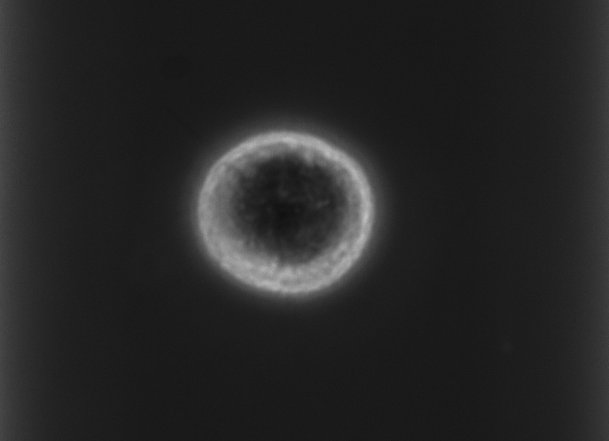

In [70]:
img= ds[0][0]
img

In [69]:
#export
def center_crop(img, size):
    new_w = new_h = size
    w, h = img.size   
    left = (w - new_w)/2
    top = (h - new_h)/2
    right = (w + new_w)/2
    bottom = (h + new_h)/2

    return img.crop((left, top, right, bottom))

In [70]:
#export
class CenterCrop(object):
    def __init__(self, size = 256):
        assert isinstance(size, int)
        self.size = size
    
    def __call__(self, img):
        return center_crop(img, self.size)

In [73]:
ds= CellDataSet(path, fm, trfms= CenterCrop(256))

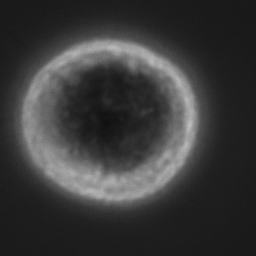

In [74]:
ds[0][0]

In [71]:
#export
class ToTensor(object): 
    def __call__(self, img): return torch.from_numpy(np.array(img))

In [76]:
ds= CellDataSet(path, fm, trfms= [CenterCrop(), ToTensor()])

In [77]:
ds[0][0].shape

torch.Size([256, 256])

## Split in train/ validation sets

In [78]:
path= Path('PCImages')

path2fm= 'FeatureMatsMerged/TheGreatCollection.txt'
path2colnames= 'FeatureMatIndex.txt'

fm= fm_from_txt(path2fm, path2colnames)

ds= CellDataSet(path, fm, trfms= [CenterCrop(), ToTensor()])
dl= DataLoader(ds)

In [72]:
#export 
import numpy as np
from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler

In [73]:
#export
def ds2dls(ds, bs, val_split = 0.2, shuffle_ds = True, random_seed = 0):

    ds_size = len(ds)
    inds = list(range(ds_size))
    split = int(np.floor(val_split * ds_size))
    if shuffle_ds:
        np.random.seed(random_seed)
        np.random.shuffle(inds)
    train_inds, val_inds = inds[split:], inds[:split]

    ts = SubsetRandomSampler(train_inds)
    vs = SubsetRandomSampler(val_inds)

    train_dl = DataLoader(ds, batch_size=bs, sampler=ts)
    valid_dl = DataLoader(ds, batch_size=bs, sampler=vs)
    
    return train_dl, valid_dl

In [81]:
bs= 4
train_dl, valid_dl= ds2dls(ds, bs) 

In [74]:
#export
def show_image(img, figsize=(3,3)):
    plt.figure(figsize=figsize)
    plt.axis('off')
    plt.imshow(img[0,:], cmap='gray')

In [75]:
#export
def show_batch(x, y, bs=4, figsize=(20,10)):
    assert len(y) == bs
    plt.figure(figsize=figsize)
    columns = 5
    for i in range(bs):
        plt.subplot(bs / columns + 1, columns, i + 1)
        plt.axis('off')
        plt.title(f'y: {y[i]}')
        plt.imshow(x[i,:], cmap='gray')

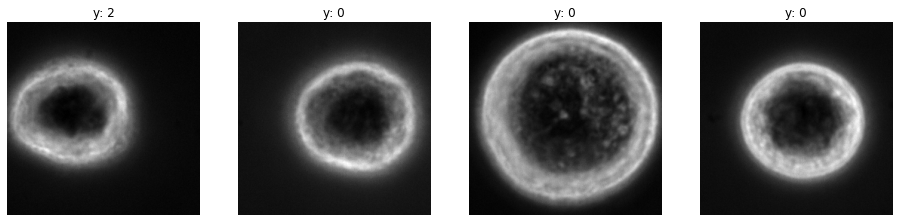

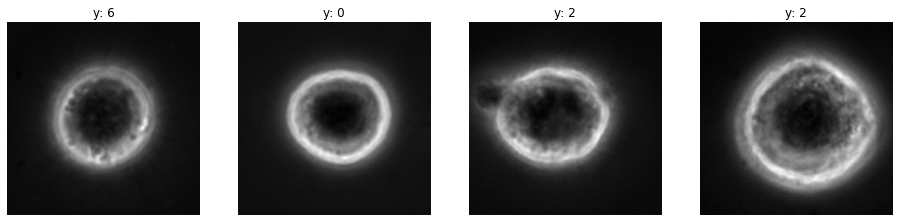

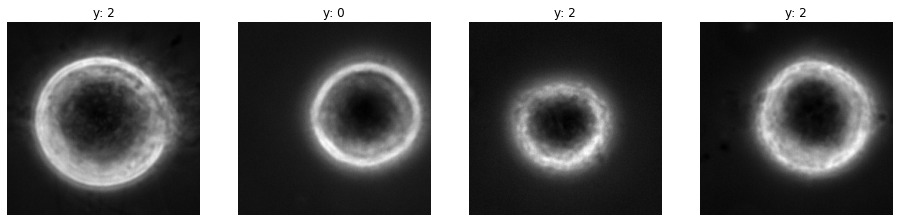

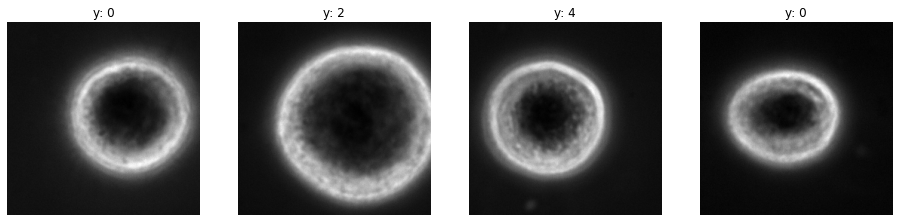

In [84]:
for i_batch, sample_batched in enumerate(train_dl):
    img= sample_batched[0]
    label= sample_batched[1]
    show_batch(img, label)
    if i_batch == 3:
        break

In [77]:
!python notebook2script.py 01_data_block.ipynb

Converted 01_data_block.ipynb to exp/nb_01.py
